# EXPLORATION_09 폐렴아 기다려라!

## Step 1. Set-up

#### 필요한 패키지(라이브러리)들을 준비하기!

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

##### 필요한 변수들을 생성

In [2]:
## 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
## X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

## 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' ## *은 모든 디렉토리와 파일을 의미한다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 가져오기

#### 데이터를 아까 다운받은 걸 가져오자~(이미 train, validation, test 로 나눠져 있다.)  
#### 데이터의 개수를 체크해보자.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


#### train 안에는 5216개  
#### test 안에는 624개  
#### val 안에는 16개가 있다.  
#### val 개수가 너무 없기 때문에 train 에서 데이터를 가져와서 나눠보자~

In [4]:
## train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

## 모아진 filenames를 8:2로 나눈다.  (val 개수가 너무 적기 때문에 train:val 을 80:20으로 분할)
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### 파일 경로확인!!

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


#### 위에 결과값을 확인해보니까 정상보다는 폐렴 이미지 수가 3배 더 많다.  
#### 우리가 사용할 CNN 모델이 데이터끼리 balance가 좋아야 good

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
## 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   ## 폐렴이면 양성(True), 노말이면 음성(False)

#### 이미지 데이터는 사이즈가 제각각일 것임.  
#### 그래서 이미지 사이즈를 통일 시키고 사이즈를 줄이자.

In [10]:
## 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) ## 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) ## float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) ## 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

## 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) ## 라벨 검출
    img = tf.io.read_file(file_path) ## 이미지 읽기
    img = decode_img(img) ##이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
## 이미지가 resize 잘 되었는지 라벨이 들어갔는지 확인~~

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
## test데이터 셋 만들고 개수까지 확인해보기

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
## prefetech() 를 사용하면 학습 데이터를 나눠서 읽어온다. 
## 그래서 첫 번째 데이터를 GPU 에서 학습하는 동안 두 번째 데이터를 준비해,
## 리소스의 유휴 상태를 줄일 수 있다.

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

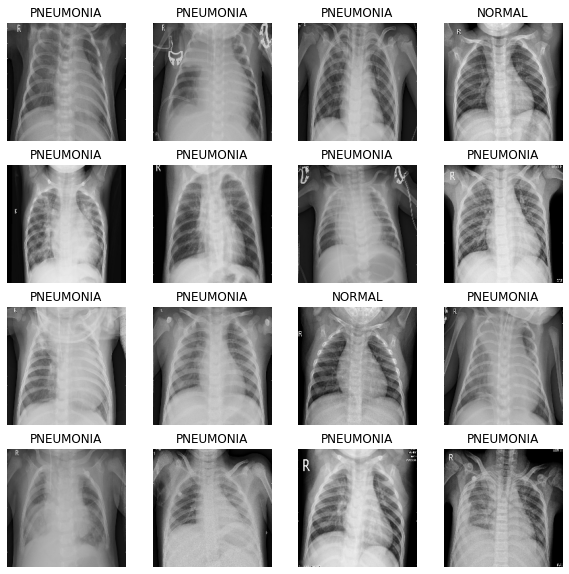

In [15]:
## 이미지 배치를 입력하면 여러장의 이미지를 보여준다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

#### 이미지 처리하는 것에 특화 되어있는 모델 CNN을 모델링해서 사용해보자!

In [16]:
## 먼저 Convolution block 을 만들자. 
## 구성은 COnv 두 번 진행하고 BatchNormalization을 해서 Gradient vanishing, Gradient Exploding을 해결
## 마지막으로 Max Pooling을 한다.

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
## Dense Block 을 만든다.

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
## 모델 성능 향상을 위해서 모델링

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

#### 아까 위에서 정상 데이터보다는 비정상 데이터가 훨씬 많았었다.   
#### 한 라벨이 너무 많은 경우에는 imbalance 하다고 하는데 이런 경우에는 학습효과가 좋지 않다.

In [19]:
## weight_for_0 은 "Nomal" 이미지에 사용할 weight
## weight_for_1 은 "Pneumonia"이미지에 사용할 weight

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

In [20]:
## 먼저 GPU 선택  
## 모델은 위에서 만들었던 build_model() 을 model 선언한다.

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
## 모델을 fit하기

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 189ms/step - loss: 0.4458 - accuracy: 0.7783 - precision: 0.9427 - recall: 0.7472 - val_loss: 0.5951 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2539 - accuracy: 0.9004 - precision: 0.9693 - recall: 0.8944 - val_loss: 0.9252 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2114 - accuracy: 0.9193 - precision: 0.9769 - recall: 0.9131 - val_loss: 0.1497 - val_accuracy: 0.9308 - val_precision: 0.9150 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 50s 194ms/step - loss: 0.1735 - accuracy: 0.9327 - precision: 0.9816 - recall: 0.9269 - val_loss: 0.1269 - val_accuracy: 0.9490 - val_precision: 0.9384 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1823 - accura

## Step 7. 결과 확인

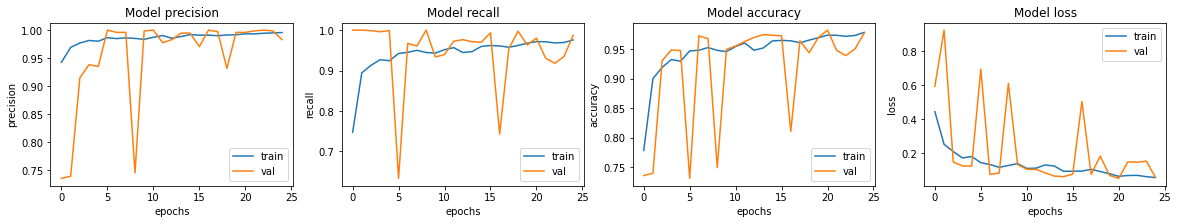

In [22]:
## 결과를 확인하는데 그래프로 확인하고 모델의 recall, accuracy 등이 어떻게 바뀌는지 확인!

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
## 결과값 확인!!!!

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 1.6182 - accuracy: 0.7404 - precision: 0.7065 - recall: 1.0000
Loss: 1.618203043937683,
Accuracy: 0.7403846383094788,
Precision: 0.70652174949646,
Recall: 1.0


## ++ 성능개선

In [24]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  ## 랜덤하게 좌우를 반전한다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ## augment 적용 부분이 배치처리 함수에 추가되었다.
    ds = ds.map(
            augment,       ## augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [26]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

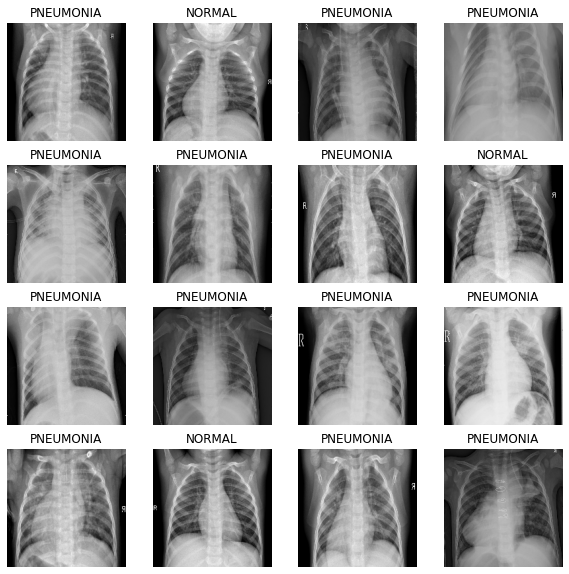

In [27]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


In [29]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 192ms/step - loss: 0.3809 - accuracy: 0.8118 - precision: 0.9535 - recall: 0.7853 - val_loss: 0.6762 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2350 - accuracy: 0.9078 - precision: 0.9745 - recall: 0.8995 - val_loss: 1.0995 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2182 - accuracy: 0.9179 - precision: 0.9720 - recall: 0.9161 - val_loss: 0.1953 - val_accuracy: 0.9115 - val_precision: 0.8924 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1968 - accuracy: 0.9265 - precision: 0.9788 - recall: 0.9211 - val_loss: 0.1701 - val_accuracy: 0.9394 - val_precision: 0.9958 - val_recall: 0.9215
Epoch 5/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1683 - accura

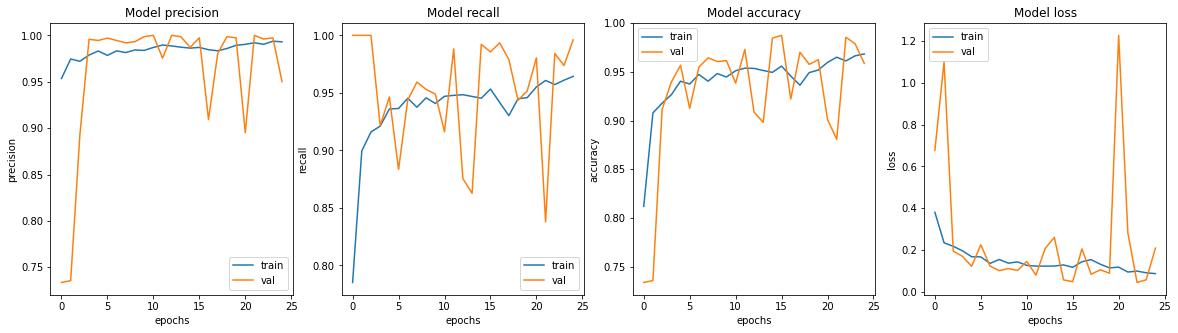

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 107ms/step - loss: 1.2081 - accuracy: 0.7051 - precision: 0.6794 - recall: 1.0000


## +++ batchnorm 제거

In [33]:
BATCH_SIZE = 16
EPOCHS = 15

In [34]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  ## 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ## augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       ## augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

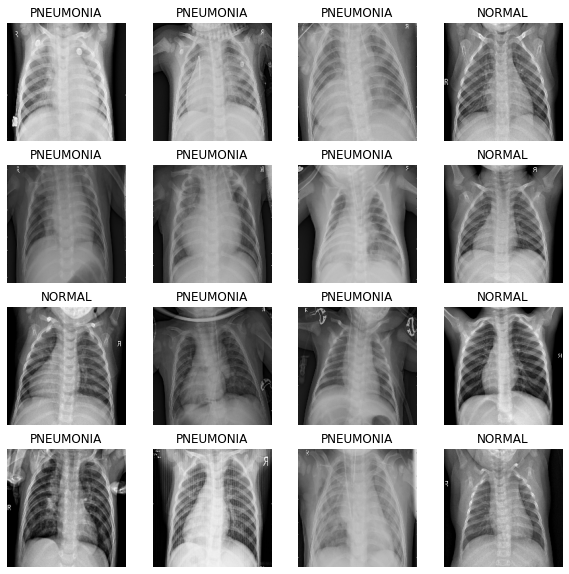

In [36]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [37]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [38]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [39]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [40]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


In [41]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# 회고!

## < 어려웠던 점>  
항상 같은 것 같지만!! 당연히 accuracy를 딱 맞추기가 어려웠던 것 같다. 그리고 모델을 모델링하는 과정에서 코드에 대한 이해도가 아직까지 부족한 점이 많아서 어려웠던 것 같다. 하나하나 찾아보면서 모델링을 해야해서 번거롭기도 했고 앞에 익스를 했던 것을 조금 참고했던 것 같다!

## <시도한 것들>  
최대한 다양하게 시도하려고 에폭도 달리해보고 실제로 폐렴 환자를 판단하기 위해서는 Recall 값이 가장 중요하다고 생각한다. 하지만 accuracy 의 값이 조금 낮아서 계속해서 모델을 바꿔보았다.그리고 Batch norm 을 제거하는 코드를 참고해서 accuracy를 높여보려고 노력했다. 근데 처음에 학습했을 때는 85를 그냥 넘겼었는ㄷㅔ 코드를 돌리면 돌릴 수록 오버피팅이 된 것인지.......넘지 못했다... 너무 아쉽지만 ! 모델을 짜는 과정에서 많은 것을 배웠다.

## < 자기 다짐>  
노드에 나와있는 코드 뿐만 아니라 다양한 노드를 보면서 코드에 대한 공부가 필요하다고 느꼈다. 폐렴 진단기를 성능개선 할 때 모델이나 다양한 시도가 필요했는데 각 코드에 대한 이해력이 부족해서 좀 더 어려웠던 것 같다... 어 ? 어디서 본 코드인데..이러고 또 찾아보니까 시간이 많이 걸렸던 것 같아서 이제 미루지 말고 할 때 하나하나 신경써서 공부하면서 해야겠다고 느꼈다.